# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

## **Creating the workspace**

**Mount your drive**

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

PATH = "/content/gdrive/MyDrive"
%cd $PATH

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


**Clone GitHub repository**


In [7]:
#!git clone https://github.com/madilabcode/scNET
%cd "./scNET"

/content/gdrive/MyDrive/scNET


**Download example data - as an h5ad object**

In [8]:
import gdown
download_url = f'https://drive.google.com/uc?id=1b4iCuwf0ySQxz7o1w0itSEOinCYnIjuR'
output_path = './Data/example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1b4iCuwf0ySQxz7o1w0itSEOinCYnIjuR
From (redirected): https://drive.google.com/uc?id=1b4iCuwf0ySQxz7o1w0itSEOinCYnIjuR&confirm=t&uuid=6c88224b-dfe7-4bbe-a651-01c1b9a2f124
To: /content/gdrive/MyDrive/scNET/Data/example.h5ad
100%|██████████| 129M/129M [00:01<00:00, 70.3MB/s]


'./Data/example.h5ad'

**Downlaod Packages**

In [9]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

#!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install scanpy
!pip install mygene
!pip install gseapy
!pip install matplotlib datashader bokeh holoviews scikit-image colorcet igraph leidenalg

**Imports**

In [10]:
import os
import torch
from main import main
import warnings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## **Train the model - the model, embeddings, and KNN will be saved**
### Here we trained the model for only 50 epochs to demonstrate the usage of the framework, without retching optimal results. 50 epochs should take around 10 minutes of run time on a GPU.


### **The following parameters need to be provided to the main function in order to start training the model:**

**path:** The directory for the h5ad object.

**human_flag:** Is the data from human (True) or mouse (False)?

**pre_processing_flag:** Should a basic pre-processing pipeline be applied to the object?

**number_of_batches:** The number of batches for the training.

**split_cells:** If the number of cells is too large, we should split the cells into subsets to reduce GPU memory consumption. If true, the cells will be split.

**model_name:** A unique name for the project, which will be used in the outputs of the model.

### **The function will save the following:**

**cell_embedding:** A new dense representation of the cells under the Embedding folder.

**gene_embedding:** A new dense representation of the genes under the Embedding folder.

**trained_model:** The complete trained model under the Models folder.

**new_knn:** The new and pruned KNN network, but only if the split_cells flag is set to False.

In [11]:
main(path = r"./Data/example.h5ad", pre_processing_flag=False, human_flag=True,number_of_batches=1, split_cells= True, max_epoch=50, model_name = "_example")

higly express: 7035
N genes: (9596, 902)
None
3
tensor(3.3946, device='cuda:0', grad_fn=<AddBackward0>)
row loss:1.3977203369140625, col loss:1.9969075918197632
Epoch: 000, AUC: 0.7698, AP: 0.7207
tensor(3.1668, device='cuda:0', grad_fn=<AddBackward0>)
row loss:1.206320881843567, col loss:1.9604346752166748
Epoch: 010, AUC: 0.8281, AP: 0.8442
best result of model with auc: 0.8280573479152342
tensor(3.0515, device='cuda:0', grad_fn=<AddBackward0>)
row loss:1.1517488956451416, col loss:1.8997031450271606
Epoch: 020, AUC: 0.8638, AP: 0.8737
best result of model with auc: 0.8638254528074762
tensor(2.9558, device='cuda:0', grad_fn=<AddBackward0>)
row loss:1.1185332536697388, col loss:1.8372260332107544
Epoch: 030, AUC: 0.8582, AP: 0.8716
best result of model with auc: 0.8581669846519023
tensor(2.8760, device='cuda:0', grad_fn=<AddBackward0>)
row loss:1.105540156364441, col loss:1.7704386711120605
Epoch: 040, AUC: 0.8508, AP: 0.8692
best result of model with auc: 0.8508271606010714


**Example of using the gene embedding for creating co-embedded network and performing KEGG prediction**

**Load all the relevant embeddings**

In [12]:
import coEmbeddedNetwork as cen
gene_embedding, cell_embedding, node_feature = cen.load_embeddings("_example")

**We can plot the genes UMAP**

         Falling back to preprocessing with `sc.pp.pca` and default params.


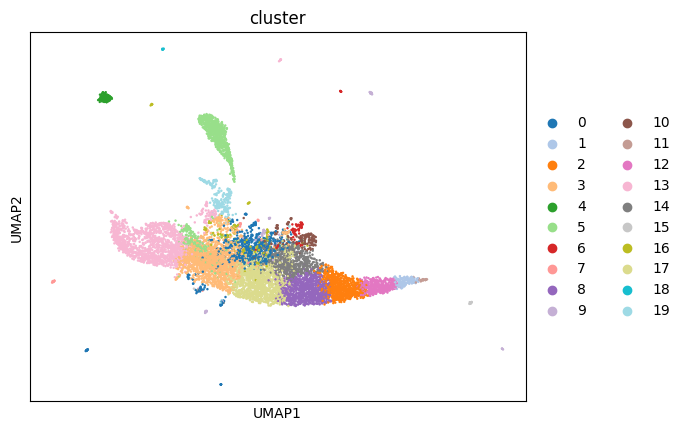

array([12, 12, 12, ..., 13, 13, 16], dtype=int32)

In [13]:
cen.plot_gene_umap_clustring(gene_embedding)

**Also plot the cells UMAP**

         Falling back to preprocessing with `sc.pp.pca` and default params.


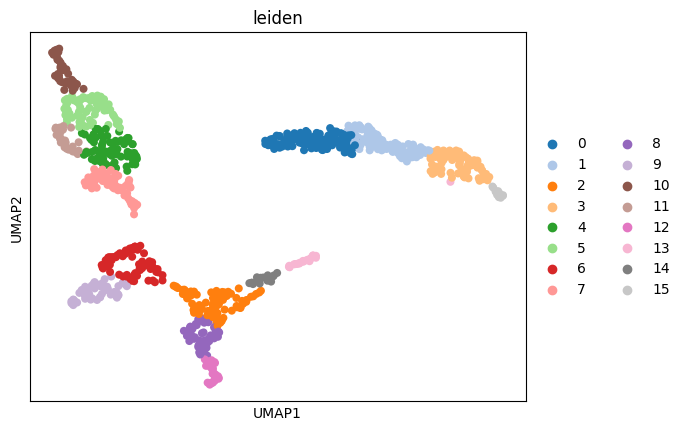

In [14]:
cen.plot_umap_cells(cell_embedding)

**Creating the co-embedded network, is it modular?**

In [15]:
graph, mod = cen.build_co_embeded_network(gene_embedding, node_feature)
mod

0.6765867398630643

**Now we can use the network to predict KEGG pathway membership in a cross-validation**

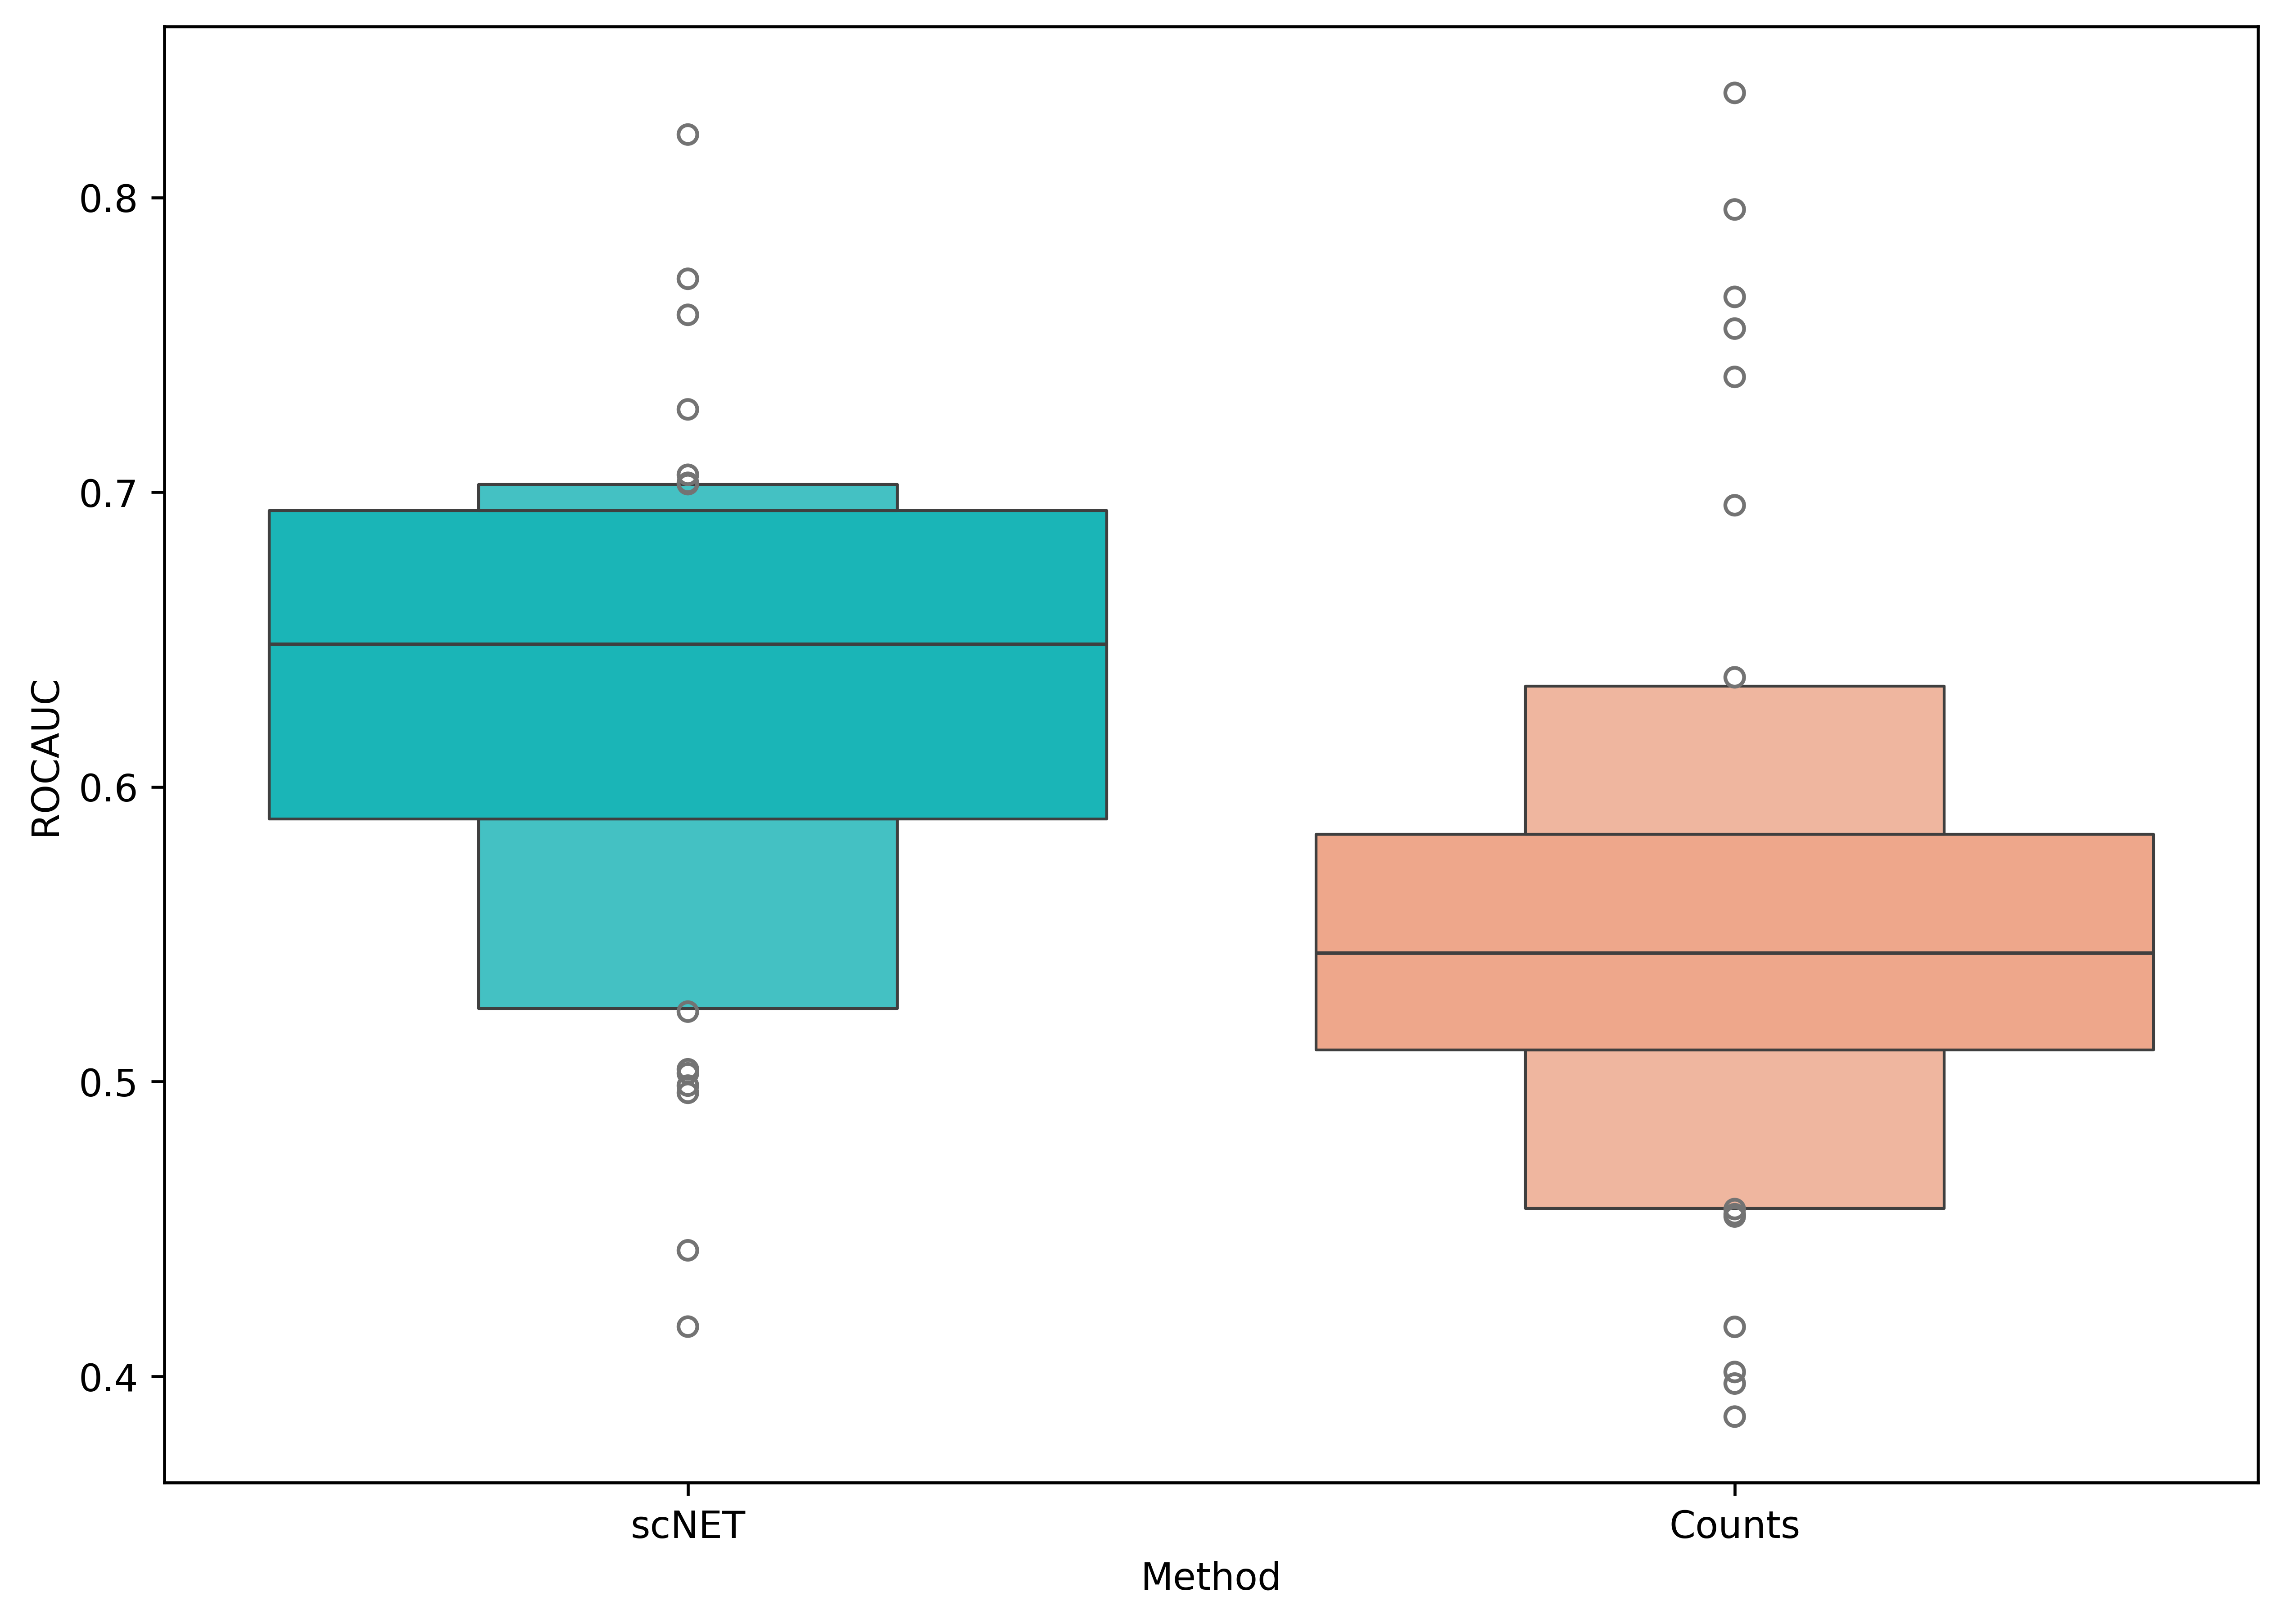

,ROCAUC,Method
0,0.690290,scNET
1,0.442761,scNET
2,0.502824,scNET
3,0.702279,scNET
4,0.703189,scNET
...,...,...
95,0.470361,Counts
96,0.566929,Counts
97,0.739135,Counts
98,0.416790,Counts


In [16]:
cen.predict_kegg(gene_embedding,node_feature)